# **HOUSE PRICE PREDICTION**

Sử dụng các mô hình đã học hoặc nâng cao để áp dụng vào bài toán dự đoán giá nhà

In [14]:
# Khai báo thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
# Load data
train_data = pd.read_csv('../preprocessing_data/train.csv')
test_data = pd.read_csv('../preprocessing_data/test.csv')
train_data.head()

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,-0.244415,-0.257308,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.621525,...,0,0,0,1,0,0,0,1,0,12.247699
1,0.547599,0.035675,0.0,0.0,0.0,0.0,0.0,0.0,2.630317,0.062576,...,0,0,0,1,0,0,0,1,0,12.109016
2,-0.072504,0.399864,0.0,0.0,-1.0,0.0,0.0,0.5,0.000000,0.580380,...,0,0,0,1,0,0,0,1,0,12.317171
3,-0.549090,0.023685,0.0,0.0,-1.0,0.0,0.0,0.5,0.000000,-1.228865,...,0,0,0,1,0,0,0,0,0,11.849405
4,0.734014,0.944281,0.0,0.0,-1.0,0.0,0.0,1.0,0.000000,0.559792,...,0,0,0,1,0,0,0,1,0,12.429220


In [16]:
# Seperate features and target variable
X_train = np.array(train_data.drop(['SalePrice'], axis=1))
y = np.array(train_data.SalePrice)

In [17]:
X_train.shape

(1458, 228)

## 1. MODELING

Trong model evaluation, thường thì ta sẽ chia toàn bộ data làm 2 tập train và test. Tuy nhiên data khá nhỏ, nên nếu chia như vậy, thì có lẽ mô hình sẽ dễ bị overfitting, do đó, ta dùng `cross-validation` để train mô hình.


Đề bài yêu cầu đánh giá mô hình bằng độ đo RMSE, tuy nhiên do target variable đã được biến đổi qua log(1 + y), nên MSE cho log(1 + y) là MSLE - Mean Squared Logarithmic Error.

In [18]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

## 1.1 Regularized Regressions

### 1.1.1 Ridge

In [19]:
from sklearn.linear_model import Ridge, Lasso

Best lambda: 13.8
RMSLE: 0.1157173637684539


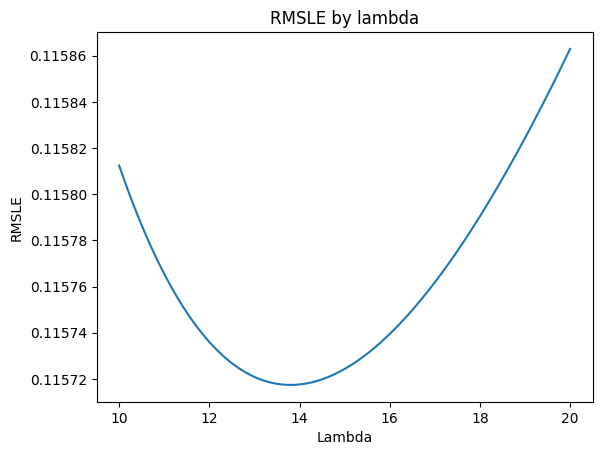

In [20]:
lambda_list = list(np.linspace(10, 20, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [21]:
ridge = Ridge(alpha=13.8)

### 1.1.2 Lasso

Best lambda: 0.0005808080808080809
RMSLE: 0.11537177658532985


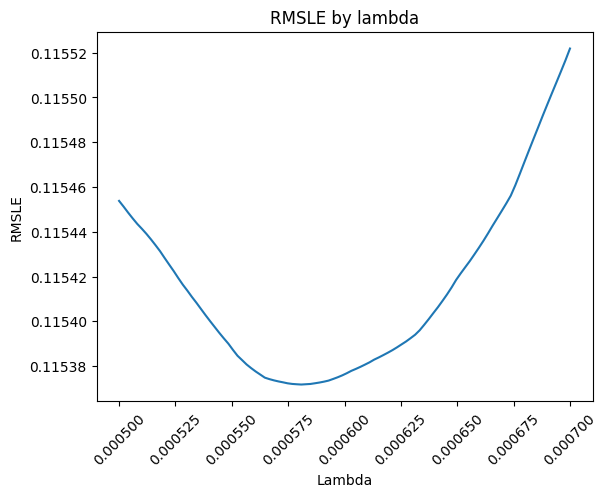

In [22]:
lambda_list = list(np.linspace(0.0005, 0.0007, 100))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=lambda_, max_iter=1000)) for lambda_ in lambda_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xticks(rotation = 45)
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [23]:
lasso = Lasso(alpha=0.00058, max_iter=1000)

## 1.2 XGBRegressor

In [24]:
from xgboost import XGBRegressor

Tìm parameter tốt nhất cho model bằng phương pháp Hyperparameter: `Bayesian Optimization` 

In [25]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.randint('max_depth', 1, 5),  
        'gamma': hp.uniform('gamma', 0, 1),
        'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.05, 0.1]),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' :  hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.randint('min_child_weight', 0, 10),
        'n_estimators': hp.randint('n_estimators', 1000, 2500)
    }

# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(params):
    
    xgboost = XGBRegressor(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

print('Best hyperparameters:', best)

100%|██████████| 100/100 [10:04<00:00,  6.05s/trial, best loss: 0.013841801262284964]
Best hyperparameters: {'colsample_bytree': 0.3760517252830441, 'gamma': 0.00016532825329085982, 'learning_rate': 2, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 1462, 'reg_alpha': 0.7240677367001701, 'reg_lambda': 0.908746333219743}


In [26]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=3,
                   min_child_weight=7,
                   gamma=0.00435,
                   subsample=0.65,
                   colsample_bytree=0.1761,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.41578,
                   reg_lambda=0.8678,
                   n_jobs=2)
getRMSLE(xgb)

0.11665545482038805

## 1.2 LGBMRegressor

In [27]:
from lightgbm import LGBMRegressor

Tìm parameter tốt nhất cho model bằng phương pháp Hyperparameter: `Bayesian Optimization` 

In [28]:
space={'max_depth': hp.randint('max_depth', 1, 5),
        'learning_rate': hp.choice('learning_rate', [ 0.02, 0.05, 0.075, 1]),
        'num_leaves': hp.randint('num_leaves', 10, 50),
        'bagging_fraction':  hp.uniform('bagging_fraction', 0, 1),
        'bagging_freq':  hp.randint('bagging_freq', 0, 10),
        'n_estimators': hp.randint('n_estimators', 100, 1000),
        'max_bin': hp.randint('max_bin', 75, 300),
        'min_sum_hessian_in_leaf ': hp.randint('min_sum_hessian_in_leaf', 1, 50),
        'min_data_in_leaf': hp.randint('min_data_in_leaf', 0, 50),
        'feature_fraction_seed': hp.randint('feature_fraction_seed', 0, 8),
        'bagging_seed': hp.randint('bagging_seed', 0, 10)
    }


# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def objective(params):
    
    lgbm =  LGBMRegressor(objective='regression', seed=1, **params) 
  
    score = cross_val_score(estimator=lgbm, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=2).mean()
    
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=200, 
            trials=trials)

print('Best hyperparameters:', best)

100%|██████████| 200/200 [02:51<00:00,  1.17trial/s, best loss: 0.01391875764917099] 
Best hyperparameters: {'bagging_fraction': 0.5270179679318694, 'bagging_freq': 1, 'bagging_seed': 1, 'feature_fraction_seed': 7, 'learning_rate': 1, 'max_bin': 242, 'max_depth': 2, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 30, 'n_estimators': 777, 'num_leaves': 23}


In [29]:
lgb = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=471,
                    num_leaves=10,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=120,
                    bagging_fraction=0.4586,
                    bagging_freq=1,
                    feature_fraction=0.24,
                    feature_fraction_seed=5,
                    bagging_seed=7,
                    min_sum_hessian_in_leaf=0)
getRMSLE(lgb)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

0.1144178513898916

## 1.3 Ensemble Models

#### 1.3.1 Bagging - Average Models

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])

        # Return average predictions
        return np.mean(predictions, axis=1)

In [31]:
avg_model = AveragingModel(models=(ridge, lasso, xgb, lgb))
getRMSLE(avg_model)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

0.11057992980305142

#### 1.3.2 Stacking - Stack Average Models

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold

In [33]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [63]:
stacked_avg_models = StackingAveragedModels(base_models = (ridge, lasso, xgb, lgb),
                                                 meta_model = ridge)
getRMSLE(stacked_avg_models)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

0.11150005039719806

## 2. Write submission

In [59]:
my_model = avg_model
my_model.fit(X_train, y)
y_pred = my_model.predict(test_data)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


AveragingModel(models=(Ridge(alpha=13.8), Lasso(alpha=0.00058),
                       XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.1761,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.00435,
                                    gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interactio...
                                    monotone_constraints=None,
                                    n_estimators=2100, n_jobs=2, nthread=-1,
                                    num_parallel_tree=None, predictor=None, ...),
                       LGBMRegressor(bagging_fraction=0.4586, bagging_freq=1,
                                     bagging_seed=7, feature_fraction=0.24,
                                     feature_fraction_seed=5,
                                     learning_rate=0.05, max_bin=120,
                                     max_depth=3, min_data_in_leaf=4,
                                     min_sum_hessian_in_leaf=0,
                                     n_estimators=471, num_leaves=10,
                                     objective='regression')))

In [62]:
submission_model = pd.read_csv('../data/sample_submission.csv')
submission_model['SalePrice'] = np.exp(y_pred) - 1
submission_model.to_csv('../submission/submission.csv', index = False)